# Explainable AI with the SHAP package in Python.

#### SHAP is a Python package that can be used to explain different mathematical models.

SHAP can provide explanations of 
* why a model made a particular prediction
* how relatively important the different variables are
* and otherwise enable transparency.

Notebook created by Nabil Arnaoot 
on 2/14/2022 

* heavily relying on SHAP documentation particularly <a href="https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html">An introduction to explainable AI with Shapley values</a>
* examples and explanations pulled from that introduction; see link for more
* with deep gratitude for help with the underlying math from Laura Riccio.

This notebook only covers only a small part of the SHAP introduction available at https://shap.readthedocs.io.

## The problem: why do we need explainability?

#### As AI models are playing a more and more important role in people's lives, we have to be able to explain how they work.

* We currently have a lot of models that are making decisions affecting human lives, but it’s very difficult to understand what those decisions are based on.
* For example, many courtrooms are using algorithms to make decisions about sentencing.  People using the algorithms to make these life-changing decisions often do not understand why a particular prisoner is granted or denied bail.
* In some cases the programmer understands how a model works but the end user does not, in other cases  nobody knows what variables a model is using.
* I have two goals for explainability in my own work: 1) to be able to understand why a model makes a particular decision and 2) be able to explain it to other people. 

## Installing shap:

Before you can run this notebook install SHAP by either:

pip install shap 

or 

conda install -c conda-forge shap

## Starting with Linear Regressions

#### We describe linear models with coefficients, but they don't explain the relative importance of variables.

We'll start out with the simplest possible model, a linear regression, and then move on from there.

Quick review of linear regressions:
* Linear regression creates a model like: housing price = 10,000 + 3 * age of house in years + 10 * rooms in house. 
* In this example, 3 and 10 are the coefficients.  They let us predict housing price plugging in the age of the house and the number of rooms. 
* However, they are not able to tell us how important the age of the house is compared to the number of rooms.  The size of the coefficients for the different variables doesn't tell us how heavily they are weighted in making the prediction.



### Now let's run a linear regression.

* We'll use the famous Boston housing dataset tracking housing prices in 1978.  

In [1]:
import pandas as pd
import shap
import sklearn

# load the Boson dataset
X,y = shap.datasets.boston()
X100 = shap.utils.sample(X, 100) 

# create a simple linear model
model = sklearn.linear_model.LinearRegression()
model.fit(X, y)

Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.
    :func:`~sklearn.datasets.fetch_california_housing`) and the Ames housing
    datas

LinearRegression()

You probably got an error message that the Boston housing dataset has ethical problems, as the data was influenced by racist policies. This dataset should not be used to draw conclusions about housing prices. We're not using it to draw conclusions about housing here, but to illustrate how the SHAP package works.

Now that we've created the model, let's look at the coefficients:


In [2]:
print("Model coefficients:\n")
for i in range(X.shape[1]):
    print(X.columns[i], "=", model.coef_[i].round(4))

Model coefficients:

CRIM = -0.108
ZN = 0.0464
INDUS = 0.0206
CHAS = 2.6867
NOX = -17.7666
RM = 3.8099
AGE = 0.0007
DIS = -1.4756
RAD = 0.306
TAX = -0.0123
PTRATIO = -0.9527
B = 0.0093
LSTAT = -0.5248


### What's wrong with coefficients?  Introducing Shapley values.

#### Coefficients are dependent on unit of measurement and scale; that's why we need Shapley values.

Right now, measuring the age of the house in years, we get a coefficient of 0.007.  
* If we measure the age of the house in minutes instead, the new coefficient will be 0.007 * 365 * 24 * 60 =367.92.  
* Suddenly age looks much more important then it did before.  
* However, the actual effect of a change in age on the prediction has not changed.  

This is why coeffiecients don't do a good enough job of explaining how much each variable affects a prediction.

To solve this problem, we'll use Shapley values.

#### A Shapley value explains how much a specific variable contributes to a specific prediction.  


You can think of a Shapely value as how much a prediction changes when a new variable is added; how much value is added by each new variable.

The underlying math for Shapley values is extremely complex.  However, in the case of linear regressions, they become much more simple to calulate.  



#### The next graph shows how number of rooms predicts housing price in our linear model.

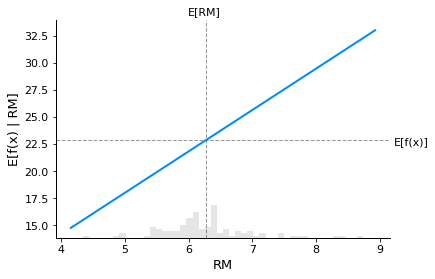

In [3]:
shap.partial_dependence_plot("RM", model.predict, X100, ice=False,
    model_expected_value=True, feature_expected_value=True)

#### The blue line shows our predictions of price; the grey lines show the average number of rooms and average housing value.

* The x axis shows the number of rooms, ranging from 4 to 9.
* The grey squares along the x access are a histogram showing the distribution of the number of rooms; most houses have around 6 rooms.
* The y axis is housing price in tens of thousands.
* The blue line shows predictions.  To find the predicted price of a house with 6 rooms, find 6 on the x axis and look up to find the point on the blue line.
* The grey dotted lines are averages.  There is a grey dotted line coming up from about 6.3; this is the average number of rooms.  The grey line running across from 22.5 is the average housing cost.

Now let's zoom in on a single prediction.

#### The next graph shows how we compute the Shapley value for a single prediction.

Permutation explainer: 507it [00:23, 11.48it/s]                         


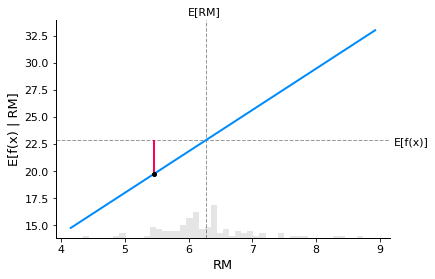

In [4]:
# compute the SHAP values for the linear model
explainer = shap.Explainer(model.predict, X100)
shap_values = explainer(X)

# make a standard partial dependence plot
sample_ind = 18
shap.partial_dependence_plot(
    "RM", model.predict, X100, model_expected_value=True,
    feature_expected_value=True, ice=False,
    shap_values=shap_values[sample_ind:sample_ind+1,:]
)

#### The Shapley value for this prediction is the red line; the distance between the average housing price and the housing price we are predicting.

We're looking at the predicted house cost when the room value is 5.5.  Take a look at the  black dot on the blue line (the number of rooms and house price for this particular prediction) and the red line showing how far this value is from the average housing price across all of Boston.  

Note that this graph only shows predicted values-- we are not looking at any actual observations from real-world houses.

#### For each variable, each prediction has a different Shapley value.

Notice that each prediction has a different Shapley value.  For each prediction we make, the weight of variables used to make a prediction will be different.

* Each (linear, additive) predictor value we are looking at has a graph like this.  If there was a different graph for price of house next door, we could measure the Shapley value for a house with 2.5 rooms on that graph, and then compare the two Shapley  graphs to see which factors had a greater influence.

#### Another way to think about Shapley values.

If we did not know the number of rooms, and we needed to predict the price of a random house, we would predict the average price of all houses in Boston.  This price is the horizontal dotted line on the graph.
* Now we've added a single variable:  the number of rooms for a particular house.  Based on this new variable, we can get improve our prediction and get more specific then the average of all house prices.
* Since more rooms means a higher price, and this particular house has fewer then the average number of rooms, we can expect a price that is lower then the average price of all costs.
* The length of the red line shows us how much lower then the average price of all houses we expect to be for this particular house.  
* In other words, the length of the red line tells us how much the fact that this house has 2.5 rooms affects our prediction of the house cost.
* This is the Shapley value.

### So what? Explaining a prediction with Shapley values.

#### Now that we've gone over what Shapley values are, let's look at how they can be used.

Earlier in the notebook we created a linear model with 14 predictor variables.  So far we've only looked at one variable-- number of rooms.  Let's use Shapley values to see how the number of rooms compares with the other 13 variables in the model to predict housing cost.


#### The next graph shows how all 14 variables affect the prediction of a single housing price.

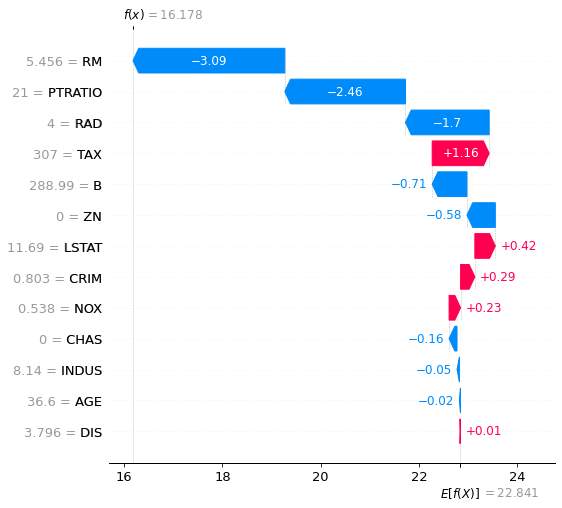

In [5]:
# the waterfall_plot shows how we use each variable to make a better prediction 
# then the average price of all houses across Boston


shap.plots.waterfall(shap_values[sample_ind], max_display=14)

#### This graph shows how influential each variable is for a single prediction.

This graph shows a single prediction.  For a house with 5.46 rooms, a ptratio of 21, rad of 4, etc, this graph
shows how important each variable is in making a prediction.
* The most important variables for this prediction are on the top, and they also have the longest bar.  For this predeiction, number of rooms is most imprtant, followed by the ptratio.
* Red squares mean the variable makes the predicted cost of this house higher then average, blue squares lower then average.
* You can also read the graph from right to left to see what the prediction will be.  Start reading from the bottom.
* The average cost of all houses is about 23.  Because this house has a dist of 3.796, we add 0.01 to the price we are predicting for this particular house.
* The next row up shows us that because this house is 36.6 years old, we subtract 0.02 from the predicted house cost.
* Continuing to move up each row in the graph, we can see how our predicted house price will increase or decrease based on a particular variable.
* In the last step, we subtact 3.09 and get our final prediction of 16.

#### This graph can explain a single prediction.

For example, if a judge runs a program and it tells her that a particular prisoner should get a longer sentence, 
the judge could look at a picture like this to see why that recommendation is being made.

The graph might show that the main reason this person is getting a long sentence is because he has been convicted of shooting three people.  Seems like a good call.

On the other hand, another prisoner's graph might show that the main reason for her long sentence is because of her zip code.  Seems like worth rethinking that one.

### Looking at more than one prediction.

#### The next two graphs show how variables work across all predictions.

So far we've showed how to explain a single prediction.  But what if we want to talk about all the predictions?    What if we want to look at the average Shapley values?

There’s a tricky thing here: Shapley values explain the difference between each observation and the mean.  If the mean is 0, half will be positive and half negative and they will average out to zero.



#### The next graph uses absolute values to show how significant variables are across all predictions:

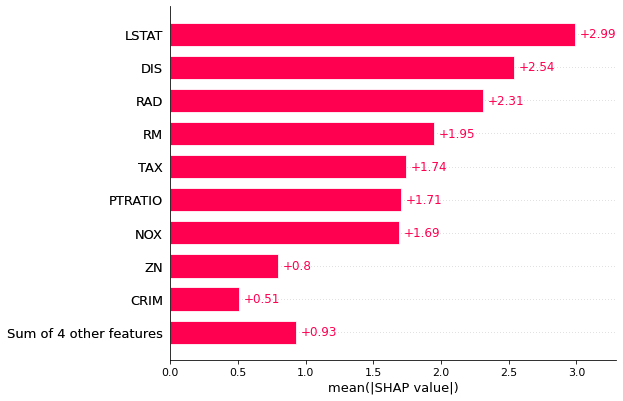

In [6]:
shap.plots.bar(shap_values)

Looking at the average impact of different variables, we can see that lstat is the most important predictor variable on average.  Room number is still important, but it's not the most important on average.

What about if we have a factor that matters a lot for a small number of observations?  We can look at the maximum Shapley values instead:

#### The next graph shows any variables that are deeply influential, but only for a few predictions.

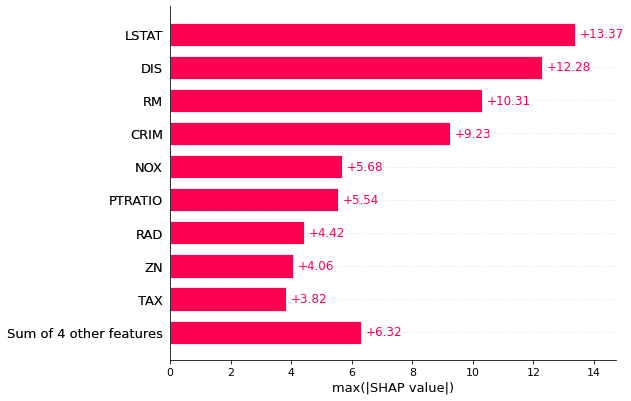

In [7]:
shap.plots.bar(shap_values.abs.max(0))

This graph will highlight if there is one variable that doesn’t influence many observations, but when it does it makes a huge difference. In our bail example, we might want prior conviction for murder to work like this.  Most people don't have a conviction for murder so it doesn't impact the decision, but in those cases where someone does have a previous murder conviction it should trump other factors and lead to a decision to deny bail.

There's a lot more out there-- Shapley values can be used to explain a lot of different kinds of models. 

### Assumptions and options

#### So far we've looked at a very simple model, which makes Shapley values easier to calculate.

So far we've been assuming:
* We are looking at a linear regression model— which simplifies the math and makes Shapley values easier to calculate.  
* We're assuming every predictor is independent.  
* We're also looking at additive models.  In the graphs above, you see that you can add the effect of each variable to get the final prediction.

#### The SHAP package can also explain more complex models.

* SHAP can also work with nonlinear models, non-additive models, and correlated features. These are more complicated and require more research. 


SHAP gets more exciting when it's used on more complicated models.  

#### The next image shows how SHAP can explain a model analyzing a block of text:

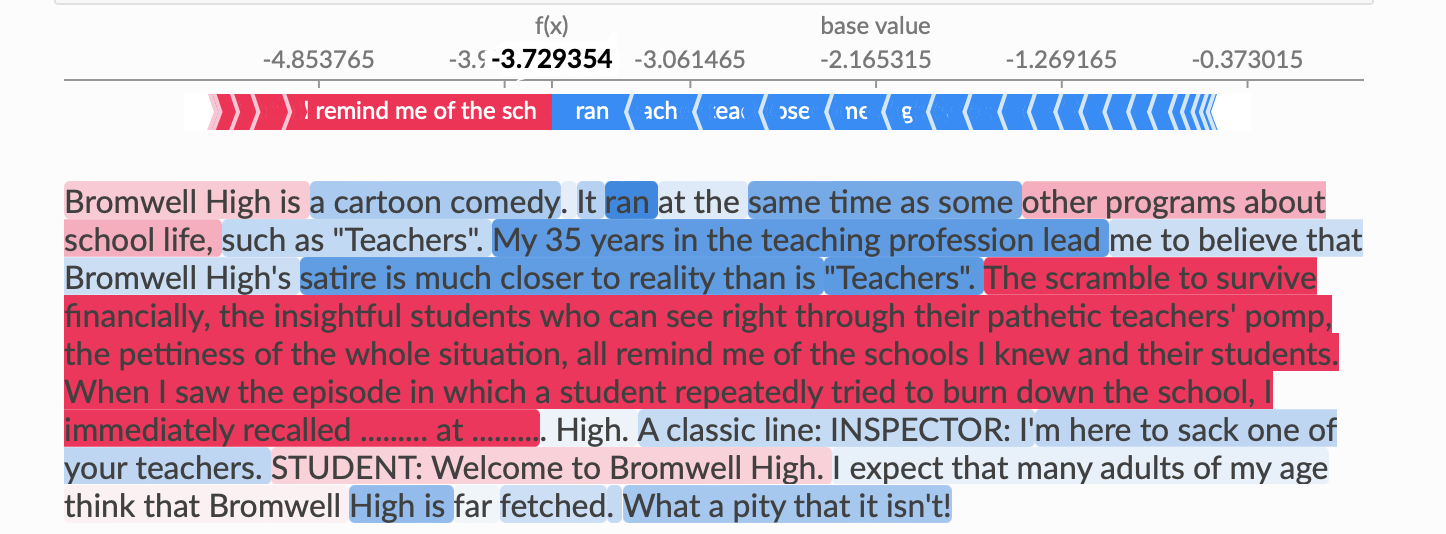

In [8]:
from PIL import Image # just a picture, not the real thing
img = Image.open('nlp_explained.png')
display(img) 

We haven't gotten into this kind of model yet, I'm hoping we'll study them in our machine learning class.  Still, you can see how useful this image is in understanding why a model comes to a particular conclusion about a paragraph of text.

## Conclusion

#### Use the SHAP package along with your models to make them more explainable.

This has been a quick introduction into why we need explainability, what shapley values are, and how to use the SHAP package in Python to explain your models.  

As more and more life-threatening decisions are made by models that are designed to be incomprehensible, we absolutely must do a better job explaining how our models work.

This has just been a start-- I've covered only some of the material from the first introduction to the SHAP package documentation at https://shap.readthedocs.io.  Dig in and let me know what you find!
